# **End-to-End Machine Learning Model**

**Elaborado por**
- **Enzo Infantes Zúñiga**
- 📧 [enzo.infantes28@gmail.com](mailto:enzo.infantes28@gmail.com)
- 🔗 [enzo-infantes](https://www.linkedin.com/in/enzo-infantes/)

<img src='https://upload.wikimedia.org/wikipedia/commons/4/41/BSE_primary_logo_color.jpg' width=300 />

# **Descripción del Caso**

La empresa proporciona servicios de Call Center enfocados en diversas áreas, como gestión de ventas, cross-selling, comunicaciones generales, retención de clientes y cobranzas, entre otros. Su principal indicador de rendimiento (KPI) es la **contactabilidad de los leads**, definida como:

$$
Contactabilidad = \frac{CE}{CE + CNE}
$$

Donde:  
- **CE**: Contacto Efectivo  
- **CNE**: Contacto No Efectivo  

Actualmente, la empresa enfrenta el desafío de recuperar el mayor monto adeudado posible. Sin embargo, en los últimos meses, el ratio de contactabilidad ha disminuido en 4 puntos porcentuales, pasando de un promedio del **34%** en contactos efectivos a solo un **30%**.

**Problema Principal**
¿Cómo puede la empresa mejorar la contactabilidad en la gestión de cobranzas para diferentes campañas, asegurando así una mayor efectividad y recuperación de deuda?

**Base de Datos**
| Variable       | Descripción de la variable                                                                 |
|----------------|--------------------------------------------------------------------------------------------|
| MES            | Mes de observación o periodo de ejecución.                                                 |
| CLIENTE        | Identificador del cliente o prospecto.                                                     |
| NRO_VEC_COB    | Número de veces que el cliente cayó en cobranzas.                                          |
| PDPs_ROTAS     | Número de promesas que el cliente hizo sin cumplir.                                        |
| ESTADO_PDP     | Estado de promesa de pago.{0: Sin promesa; 1: Con promesa temprana; 2: Con promesa tardía; 3: Con promesa rota.} |
| NRO_CUOTAS     | Número de cuotas adeudadas.                                                                |
| MES_0          | Deuda vencida actual.                                                                      |
| MES_1          | Deuda vencida del mes anterior.                                                            |
| MES_2          | Deuda vencida hace dos meses.                                                              |
| FECHALLAMADA   | Fecha de la gestión del lead o cliente.                                                    |
| HORA           | Hora de la gestión del lead o cliente.                                                     |
| DEUDA_TOTAL    | Deuda total al cierre del mes.                                                             |
| ESTATUS        | BT= Titulares, OTROS= No titulares                                                         |
| ACTIVACION     | Año de activación como cliente.                                                            |
| MORA           | Estado de mora. {1: Normal; 0: Deficiente}                                                 |
| TIPOCONTACTO   | Estado resultante de la llamada. {COEF: Contacto efectivo; CNE: Contacto No efectivo}       |


# **0. Librerias**

In [302]:
# Librerias Bases
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io

# Librerias de Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Librerias de Modelado
from sklearn.model_selection import (RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold, KFold, cross_val_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# librerias de Modelos
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC

# Librerias de Evaluacion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, auc, precision_score, recall_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample
import shap

# **1. BBDD**

In [282]:
df = pd.read_csv('ContactoCobranza.csv', sep=';')
print('El dataset tiene', df.shape[0], 'filas y', df.shape[1], 'columnas.')

El dataset tiene 8458 filas y 16 columnas.


In [16]:
df.head(5)

,MES,CLIENTE,NRO_VEC_COB,PDPs_ROTAS,ESTADO_PDP,NRO_CUOTAS,MES_0,MES_1,MES_2,FECHALLAMADA,HORA,DEUDA_TOTAL,ESTATUS,ACTIVACION,MORA,TIPOCONTACTO
0,201402,C00001,NaN,0,0,"<24, 48]",244.86,0.00,245.26,03/02/2014,15.0,3816.34,BT,2012.0,1.0,COEF
1,201402,C00002,<=10,0,0,>48,610.58,612.69,611.54,18/02/2014,9.0,13620.50,BT,2012.0,1.0,COEF
2,201402,C00003,<=10,>0,0,"<24, 48]",2138.73,0.00,NaN,05/02/2014,16.0,18968.50,BT,2013.0,0.0,CNE
3,201402,C00004,>10,0,0,"<24, 48]",323.07,46.85,74.26,24/02/2014,19.0,2459.84,BT,2012.0,0.0,CNE
4,201402,C00005,<=10,0,0,"<24, 48]",920.54,0.00,0.00,12/02/2014,14.0,6591.76,BT,2013.0,0.0,CNE


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8458 entries, 0 to 8457
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MES           8458 non-null   int64  
 1   CLIENTE       8458 non-null   object 
 2   NRO_VEC_COB   6376 non-null   object 
 3   PDPs_ROTAS    8458 non-null   object 
 4   ESTADO_PDP    8458 non-null   int64  
 5   NRO_CUOTAS    7779 non-null   object 
 6   MES_0         8458 non-null   float64
 7   MES_1         8458 non-null   float64
 8   MES_2         7557 non-null   float64
 9   FECHALLAMADA  8458 non-null   object 
 10  HORA          8458 non-null   float64
 11  DEUDA_TOTAL   8458 non-null   float64
 12  ESTATUS       8458 non-null   object 
 13  ACTIVACION    8458 non-null   float64
 14  MORA          8458 non-null   float64
 15  TIPOCONTACTO  8458 non-null   object 
dtypes: float64(7), int64(2), object(7)
memory usage: 1.0+ MB


In [18]:
ce = (df['TIPOCONTACTO']=='COEF').sum()
cne = (df['TIPOCONTACTO']=='CNE').sum()
contac = ce/(ce+cne)

print("El ratio de contactabilidad actual es: {:.2f}%".format((contac*100)))

El ratio de contactabilidad actual es: 29.37%


## **1.1 EAD**

array([[<Axes: title={'center': 'MES'}>,
        <Axes: title={'center': 'ESTADO_PDP'}>,
        <Axes: title={'center': 'MES_0'}>],
       [<Axes: title={'center': 'MES_1'}>,
        <Axes: title={'center': 'MES_2'}>,
        <Axes: title={'center': 'HORA'}>],
       [<Axes: title={'center': 'DEUDA_TOTAL'}>,
        <Axes: title={'center': 'ACTIVACION'}>,
        <Axes: title={'center': 'MORA'}>]], dtype=object)

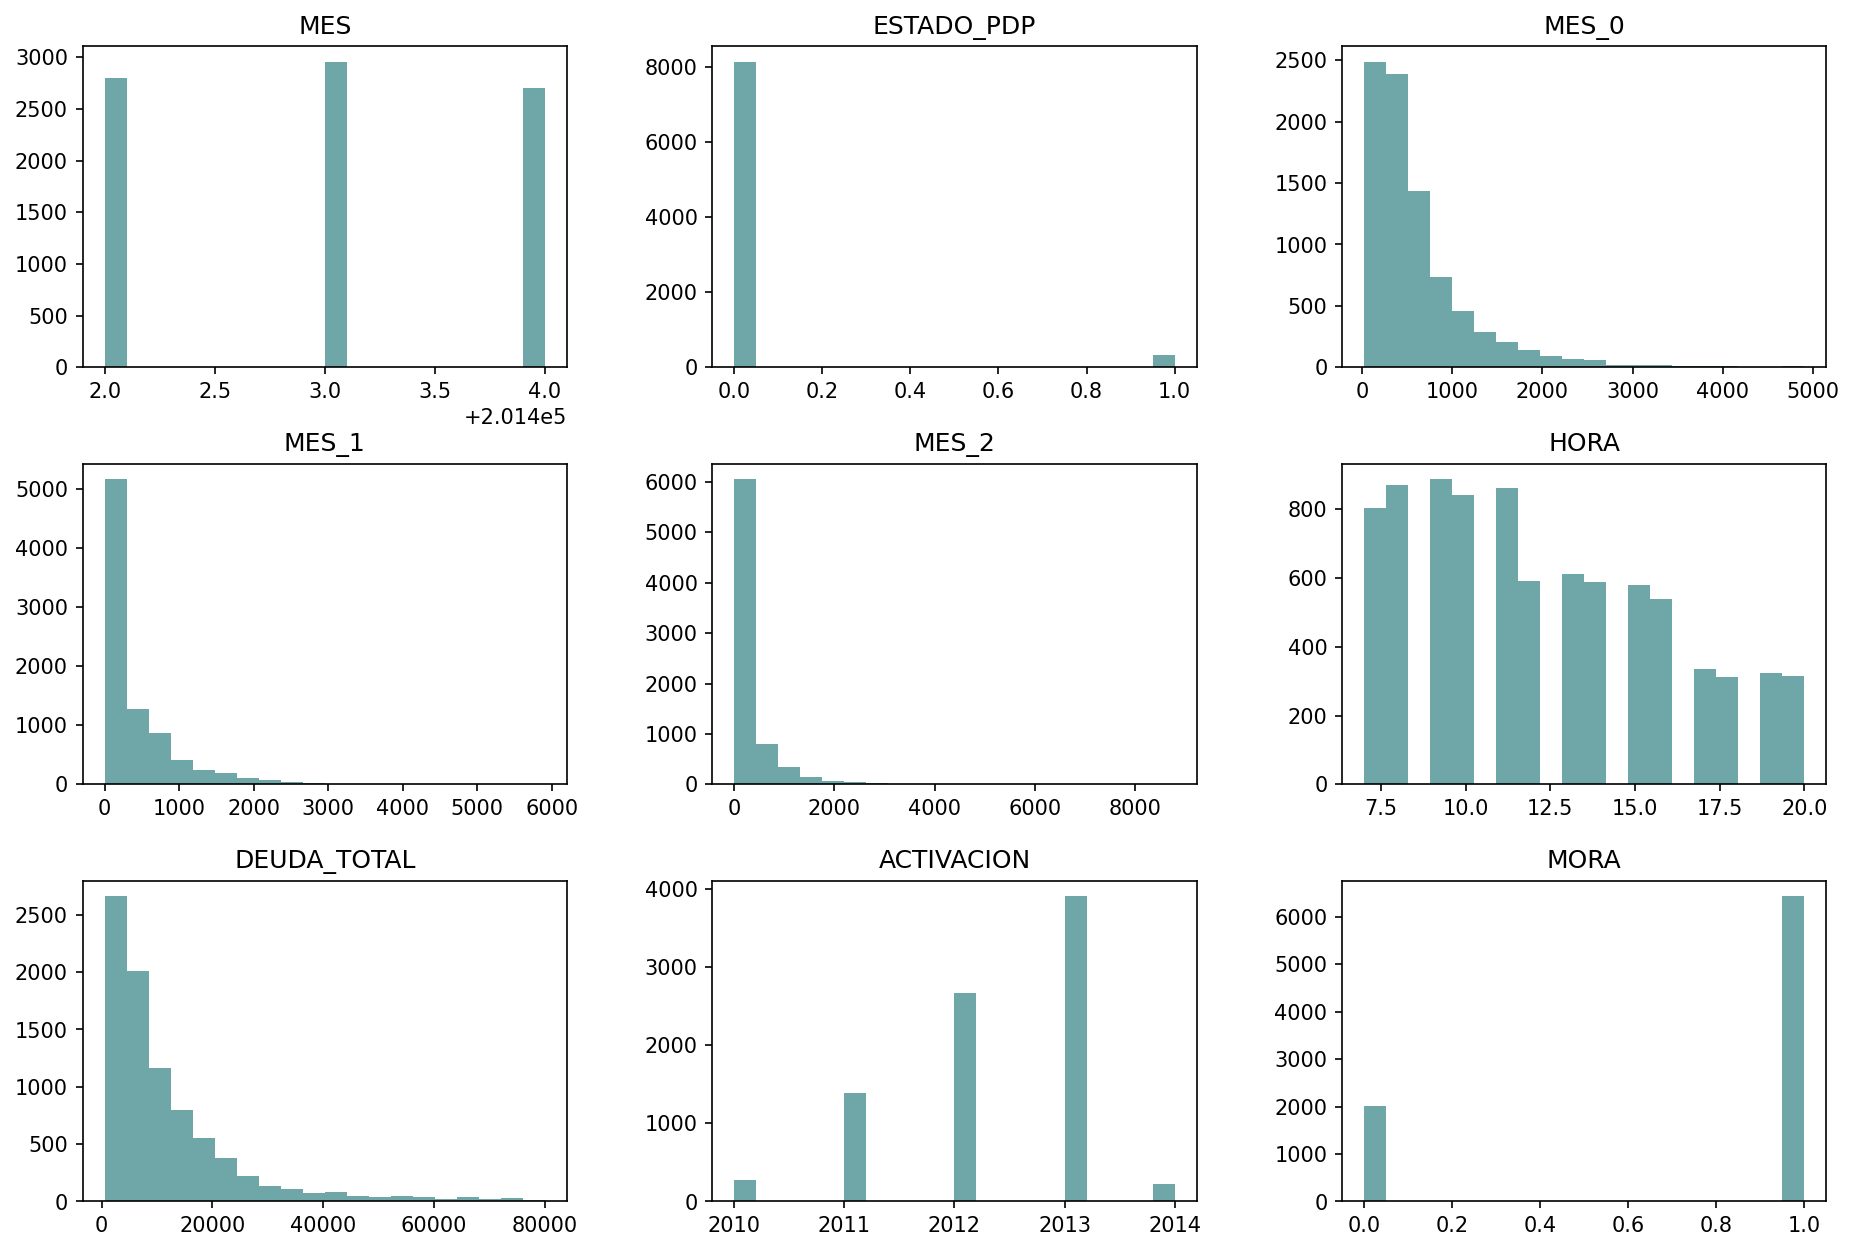

In [46]:
df.hist(bins=20, figsize=(15,10), alpha=0.9, color='cadetblue', linewidth=0.8, grid=False)

C:\Users\Enzo\AppData\Local\Temp\ipykernel_17240\115826809.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["HORA"], y=df["TIPOCONTACTO"], palette="coolwarm", ax=axes[0, 1])


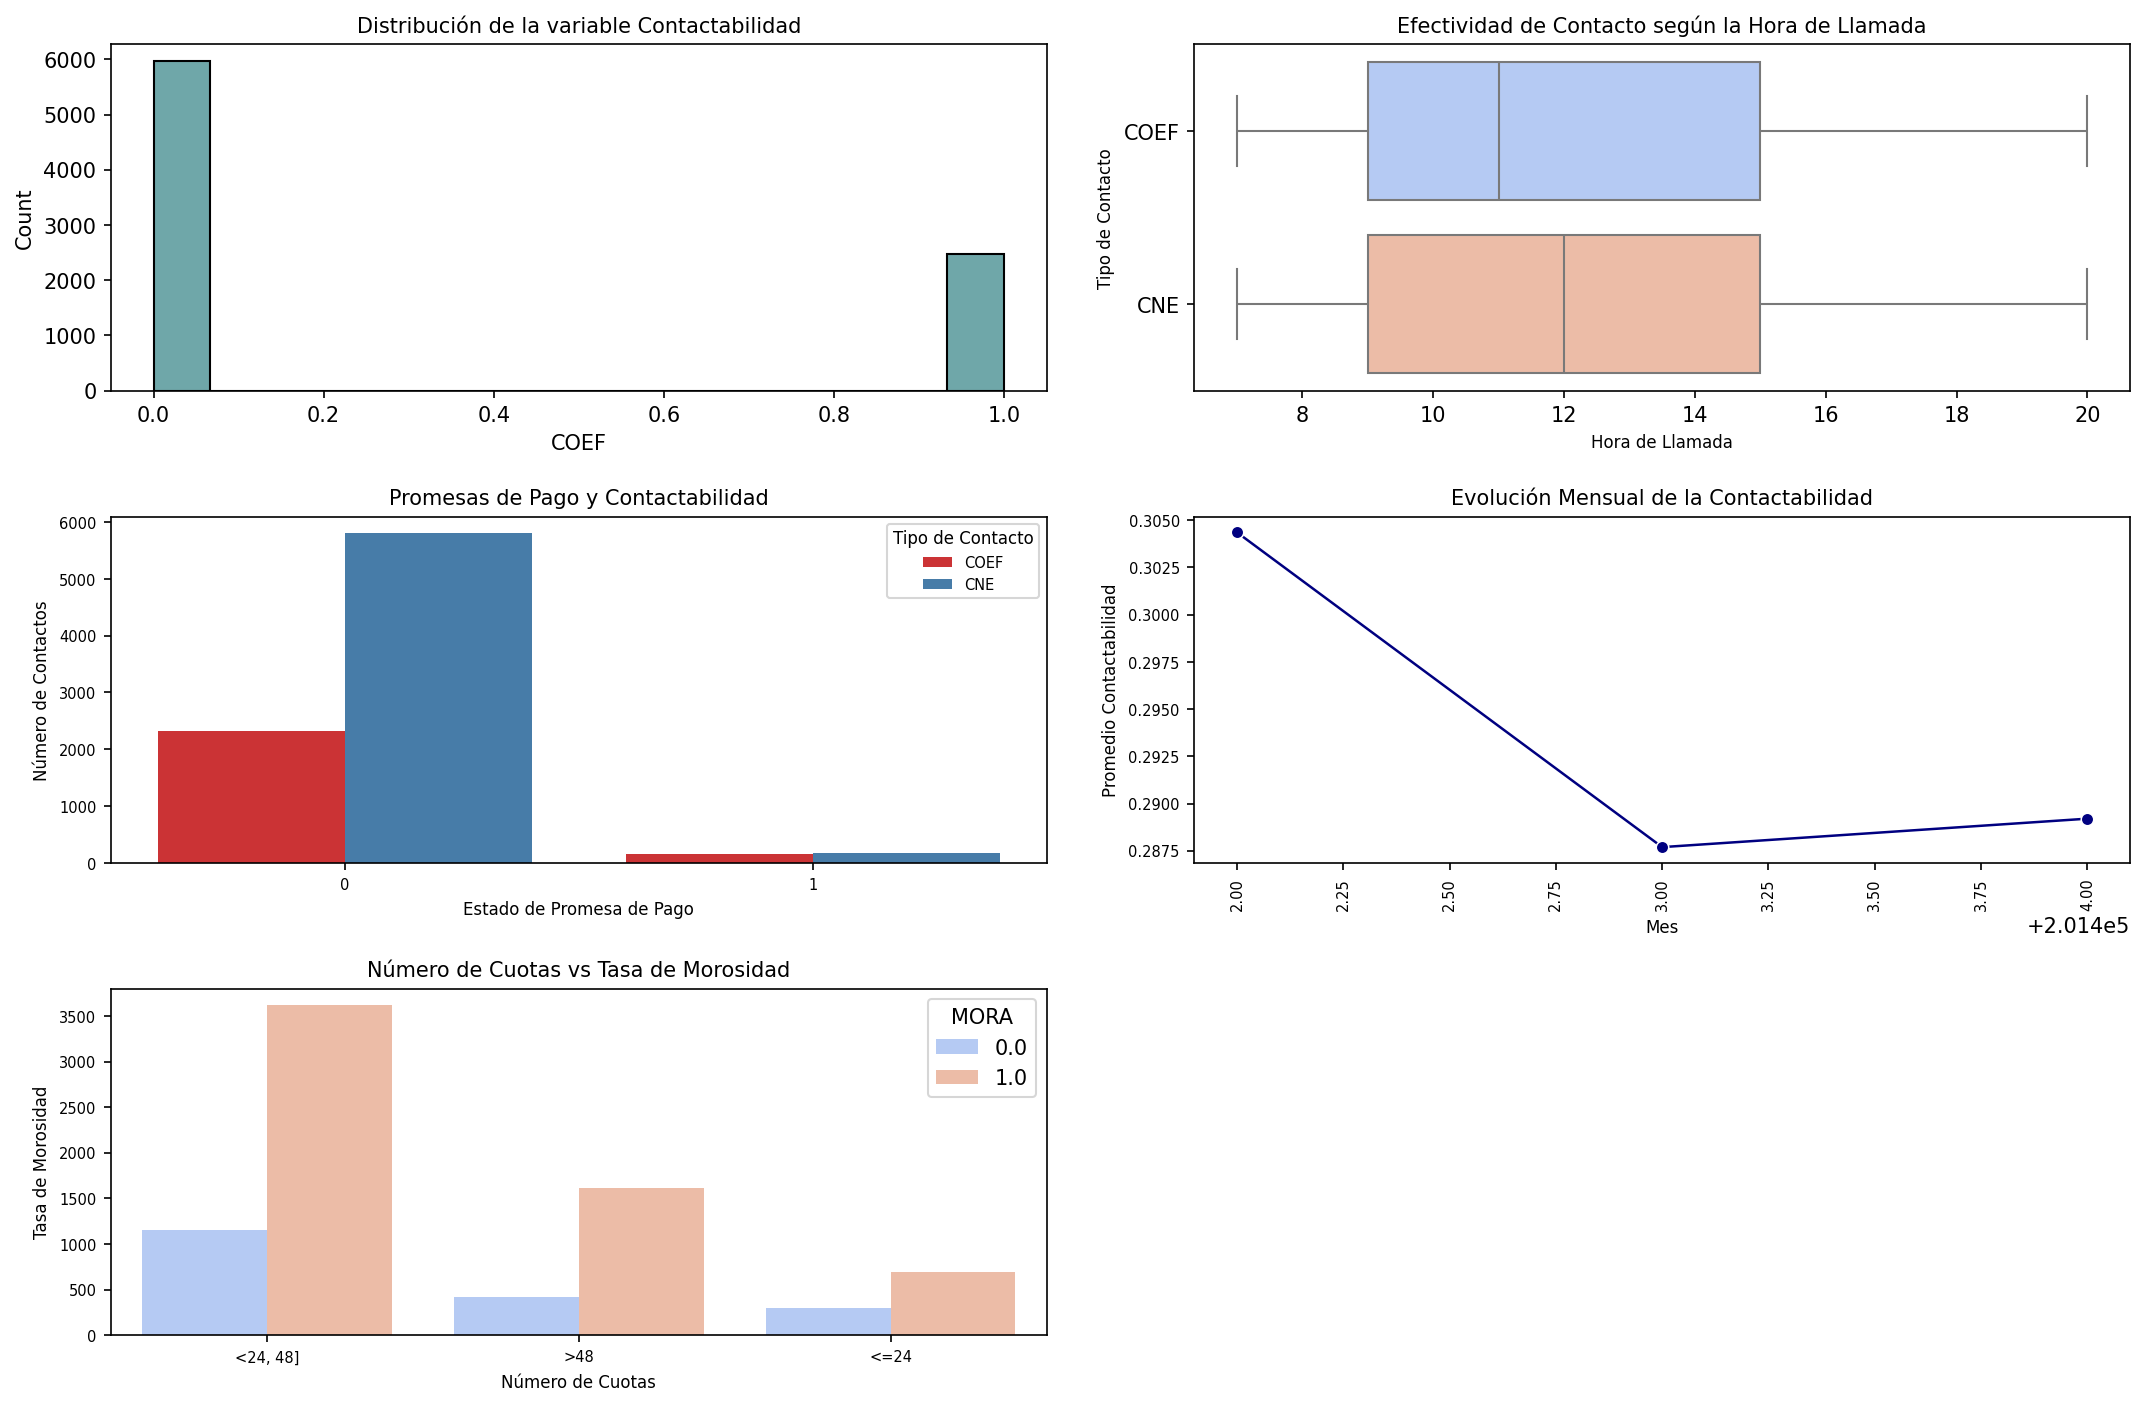

In [283]:
#################################
###### Analisis Bivariado #######
#################################

fig, axes = plt.subplots(3, 2, figsize=(15, 10))  
fig.tight_layout(pad=4) # Espacio entre subplots

# **VARIABLE TARGET**
df['COEF'] = df['TIPOCONTACTO'].apply(lambda x: 1 if x == 'COEF' else 0)

# Gráfico 1: Histograma de la variable contactabilidad
sns.histplot(df["COEF"], color="cadetblue", alpha=0.9, ax=axes[0, 0])
axes[0, 0].set_title("Distribución de la variable Contactabilidad", fontsize=10)

# Gráfico 2: Boxplot por hora de llamada  y tipo de contacto
sns.boxplot(x=df["HORA"], y=df["TIPOCONTACTO"], palette="coolwarm", ax=axes[0, 1])
axes[0, 1].set_title("Efectividad de Contacto según la Hora de Llamada", fontsize=10)
axes[0, 1].set_xlabel("Hora de Llamada", fontsize=8)
axes[0, 1].set_ylabel("Tipo de Contacto", fontsize=8)

# Gráfico 3: Relacion entre la Promesa de Pago vs Contactabilidad
sns.countplot(data=df, x="ESTADO_PDP", hue="TIPOCONTACTO", palette="Set1", ax=axes[1, 0])
axes[1, 0].set_title("Promesas de Pago y Contactabilidad", fontsize=10)
axes[1, 0].set_xlabel("Estado de Promesa de Pago", fontsize=8)
axes[1, 0].set_ylabel("Número de Contactos", fontsize=8)
axes[1, 0].tick_params(axis='x', labelsize=7)
axes[1, 0].tick_params(axis='y', labelsize=7)
axes[1, 0].legend(title="Tipo de Contacto", fontsize=7, title_fontsize=8)

# Gráfico 4: Línea de evolución mensual de Contactabilidad
coef_mensual = df.groupby("MES")["COEF"].mean()
sns.lineplot(x=coef_mensual.index, y=coef_mensual, marker="o", color="navy", linewidth=1.2, ax=axes[1, 1])
axes[1, 1].set_title("Evolución Mensual de la Contactabilidad", fontsize=10)
axes[1, 1].set_xlabel("Mes", fontsize=8)
axes[1, 1].set_ylabel("Promedio Contactabilidad", fontsize=8)
axes[1, 1].tick_params(axis='x', labelsize=7, rotation=90)
axes[1, 1].tick_params(axis='y', labelsize=7)

# Gráfico 5: Relación entre el número de cuotas y la tasa de morosidad
sns.countplot(x=df["NRO_CUOTAS"], hue=df["MORA"], palette="coolwarm", ax=axes[2, 0])
axes[2, 0].set_title("Número de Cuotas vs Tasa de Morosidad", fontsize=10)  
axes[2, 0].set_xlabel("Número de Cuotas", fontsize=8)
axes[2, 0].set_ylabel("Tasa de Morosidad", fontsize=8)
axes[2, 0].tick_params(axis='x', labelsize=7)
axes[2, 0].tick_params(axis='y', labelsize=7)

axes[2, 1].axis("off")

plt.show()

In [209]:
# Conteo de valores nulos por columna
df.apply(lambda x: x.isnull().mean()).to_frame().sort_values(by=0, ascending=False).transpose()

,NRO_VEC_COB,MES_2,NRO_CUOTAS,MES,CLIENTE,ESTADO_PDP,PDPs_ROTAS,MES_0,MES_1,FECHALLAMADA,HORA,DEUDA_TOTAL,ESTATUS,ACTIVACION,MORA,TIPOCONTACTO,COEF
0,0.246157,0.106526,0.080279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [237]:
# Conteo de Valores Duplicados
duplicados = df.duplicated().sum()

if duplicados > 0:
    df.drop_duplicates(inplace=True)
    print(f"Se eliminaron {duplicados} filas duplicadas.")
else:
    print("No se encontraron filas duplicadas.")

No se encontraron filas duplicadas.


## **1.2 Feature Store**

In [238]:
#Identificamos las variables numericas y categoricas
cate_col = []
nume_col = []
for col, dtype in df.dtypes.items():
    if dtype == np.dtype('int64') or dtype == np.dtype('float64'):
        nume_col.append(col)
    else:
        cate_col.append(col)

In [239]:
df[cate_col].nunique().sort_values(ascending=False)

CLIENTE         8458
FECHALLAMADA      61
NRO_CUOTAS         3
PDPs_ROTAS         2
NRO_VEC_COB        2
TIPOCONTACTO       2
ESTATUS            1
dtype: int64

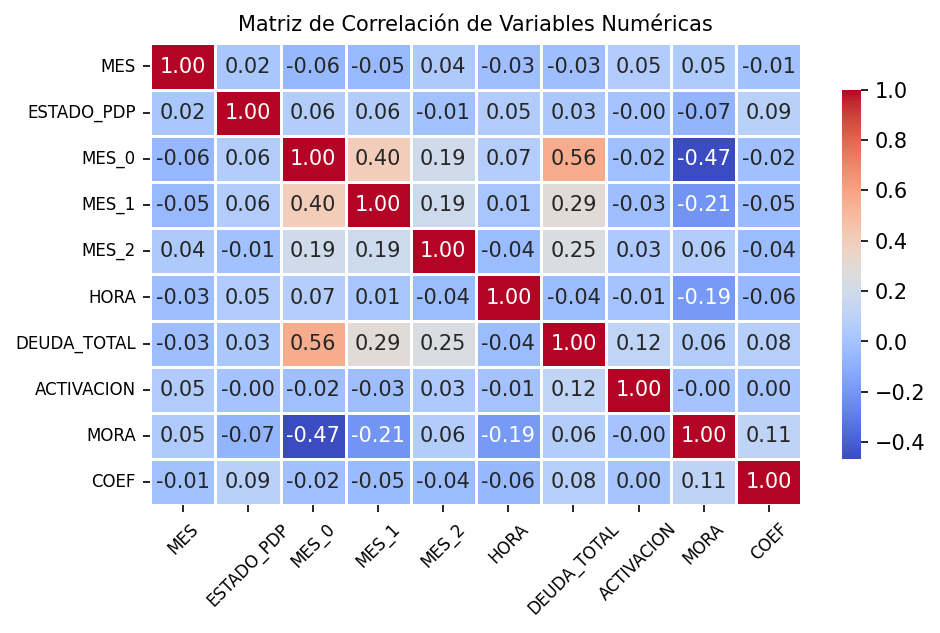

In [240]:
corr_matrix = df[nume_col].corr()

plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, cbar_kws={"shrink": 0.8}, linewidths=0.5)

plt.title("Matriz de Correlación de Variables Numéricas", fontsize=10)
plt.xticks(rotation=45, fontsize=8) 
plt.yticks(fontsize=8)
plt.show()

In [284]:
###############################################
######## Creando Variables Relevantes #########
###############################################

# 1. Variación de la deuda vencida en el último mes -> Un aumento en la deuda podría hacer que el cliente sea más propenso a responder.
df['VAR_DEUDA_VENCIDA'] = (df['MES_0'] - df['MES_1'])/df['MES_1']
df['VAR_DEUDA_VENCIDA'].replace([np.inf, -np.inf], np.nan, inplace=True) 

# 2. Promedio de deuda vencida en los últimos 3 meses -> Clientes con deudas en aumento podrían ser más difíciles de contactar.
df['PROM_DEUDA_VENCIDA_3M'] = df[['MES_0', 'MES_1', 'MES_2']].mean(axis=1)

# 3. Variable temporal de hora de contacto -> Convertir la hora a un formato más útil para el modelo.
df['HORA_CAT'] = df['HORA'].apply(lambda x: 'MORNING' if x < 12 else 'AFTERNOON' if x < 18 else 'NIGHT')
hora_cat = pd.get_dummies(df['HORA_CAT'], prefix='HORA_CAT')
df = pd.concat([df, hora_cat], axis=1)

# 4. Variable emporal de fecha de contacto -> Convertir la fecha a un formato más útil para el modelo.
df['FECHALLAMADA'] = pd.to_datetime(df['FECHALLAMADA'], format='%d/%m/%Y', errors='coerce')
df['QUINCENA'] = np.where(df['FECHALLAMADA'].dt.day <= 15, 1, 0)

# 5. Antiguedad del cliente -> Cuanto más antiguo sea el cliente, más probable es que responda.
df['ACTIVACION'] = pd.to_datetime(df['ACTIVACION'], format='%Y', errors='coerce')
df['ANTIGUEDAD'] = (pd.to_datetime('today') - df['ACTIVACION']).dt.days

C:\Users\Enzo\AppData\Local\Temp\ipykernel_17240\3008820822.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['VAR_DEUDA_VENCIDA'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [285]:
###############################################
########### Preprocesamiento de Datos #########
###############################################

# 1. Reemplazar valores categoricos por numericos en Numéros de cuotas.
df['NRO_CUOTAS'] = df['NRO_CUOTAS'].map(lambda x: 1 if x == '<=24' else (2 if x == '<24, 48]' else (3 if x == '>48' else None)))

# 2. Reemplazar valores categoricos por numericos promesas rotas. (1: 'Si', 0: 'No')
df['PDPs_ROTAS'] = df['PDPs_ROTAS'].map(lambda x: 1 if x == '>0' else 0)

# 3. Reemplazar valores categoricos para el numero de veces que el cliente cayo en cobranza. Los nulos son ceros en este caso.
df['NRO_VEC_COB'] = df['NRO_VEC_COB'].map(lambda x: 1 if x == '<=10' else (2 if x == '>10' else 0))

In [286]:
# Eliminando las columnas que no necesitamos para el modelo.
columns_to_drop = ['MES', 'CLIENTE', 'FECHALLAMADA', 'HORA', 'HORA_CAT', 'ESTATUS', 'ACTIVACION', 'TIPOCONTACTO']

df.drop(columns=columns_to_drop, inplace=True)

## **1.2 Tratamiento Missing Values**

In [ ]:
# Usamos la moda para rellenar los valores nulos en la variable Numero de Cuotas.
moda_num_cuota = df['NRO_CUOTAS'].mode()[0]
df['NRO_CUOTAS'].fillna(moda_num_cuota, inplace=True)

# Usamos el metodo KNN para imputar los valores nulos en las variables numericas restantes.
imputer = KNNImputer(n_neighbors=3)
df_imputer = imputer.fit_transform(df)
df = pd.DataFrame(df_imputer, columns=df.columns)

C:\Users\Enzo\AppData\Local\Temp\ipykernel_17240\3528242576.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['NRO_CUOTAS'].fillna(moda_num_cuota, inplace=True)


## **1.3 Target**

In [ ]:
# Vemos que nuestra muestra esta desbalanceada.
df['COEF'].value_counts(normalize=True)*100

COEF
0.0    70.631355
1.0    29.368645
Name: proportion, dtype: float64

# **2. Modelamiento**

## **2.1 Ajuste previos al Modelado**

In [ ]:
# 1. Separamos nuestro dataset en X y Y
y = df['COEF']
X = df.drop(columns='COEF', errors='ignore')

# 2. Separamos el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Balanceamos el dataset aplicando tanto un undersampling como un oversampling.
# 3.1 Undersampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# 3.2 Oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

# 4. Escalamos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# 5. Convertimos los datos a un DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)
y_train = pd.DataFrame(y_train_resampled, columns=['COEF'])

## **2.2 Modelado**

En el presente trabajo se evaluaran 3 tipos de algoritmos de clasificación:

1.   Regresión Logística
2.   Arboles de decisión
3.   Random Forest

In [328]:
def run_model_classifier(X_train, y_train, X_test, y_test, model, hyperparameters):
    """
    Función para entrenar un modelo, ajustar hiperparámetros y evaluar resultados.
    Incluye un gráfico combinado con curva ROC y matriz de confusión.

    Retorna:
        - Resultados del mejor modelo: Hiperparámetros, métricas, matriz de confusión, etc.
    """

    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV

    # 1. Crear pipeline con el modelo
    pipeline = Pipeline([('classifier', model)])

    # 2. Ajuste de hiperparámetros con GridSearchCV
    print("Iniciando búsqueda de hiperparámetros:")
    grid_search = GridSearchCV(pipeline, hyperparameters, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    # 3. Mejor modelo
    best_model = grid_search.best_estimator_
    print(f"Mejores hiperparámetros: {grid_search.best_params_}")

    # 4. Predicciones y evaluación en el conjunto de prueba
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]

    # Reporte de clasificación
    print("Reporte de clasificación:\n")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:\n")
    print(cm)

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Crear un gráfico combinado
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Subplot 1: Matriz de confusión
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Sí'], yticklabels=['No', 'Sí'], ax=axes[0])
    axes[0].set_title('Matriz de Confusión')
    axes[0].set_xlabel('Predicción')
    axes[0].set_ylabel('Real')

    # Subplot 2: Curva ROC
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_title('Curva ROC')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend(loc="lower right")

    # Mostrar los gráficos
    plt.tight_layout()
    plt.show()

    # Retorno de resultados
    return {
        'best_model': best_model,  # Incluyendo el modelo entrenado en el retorno
        'best_params': grid_search.best_params_,
        'test_roc_auc': roc_auc,
        'confusion_matrix': cm,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }


Iniciando búsqueda de hiperparámetros:


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1339: DataConve

Mejores hiperparámetros: {'classifier__C': 10, 'classifier__max_iter': 100}
Reporte de clasificación:

              precision    recall  f1-score   support

         0.0       0.63      0.54      0.58       497
         1.0       0.60      0.68      0.64       497

    accuracy                           0.61       994
   macro avg       0.61      0.61      0.61       994
weighted avg       0.61      0.61      0.61       994

Matriz de confusión:

[[268 229]
 [157 340]]


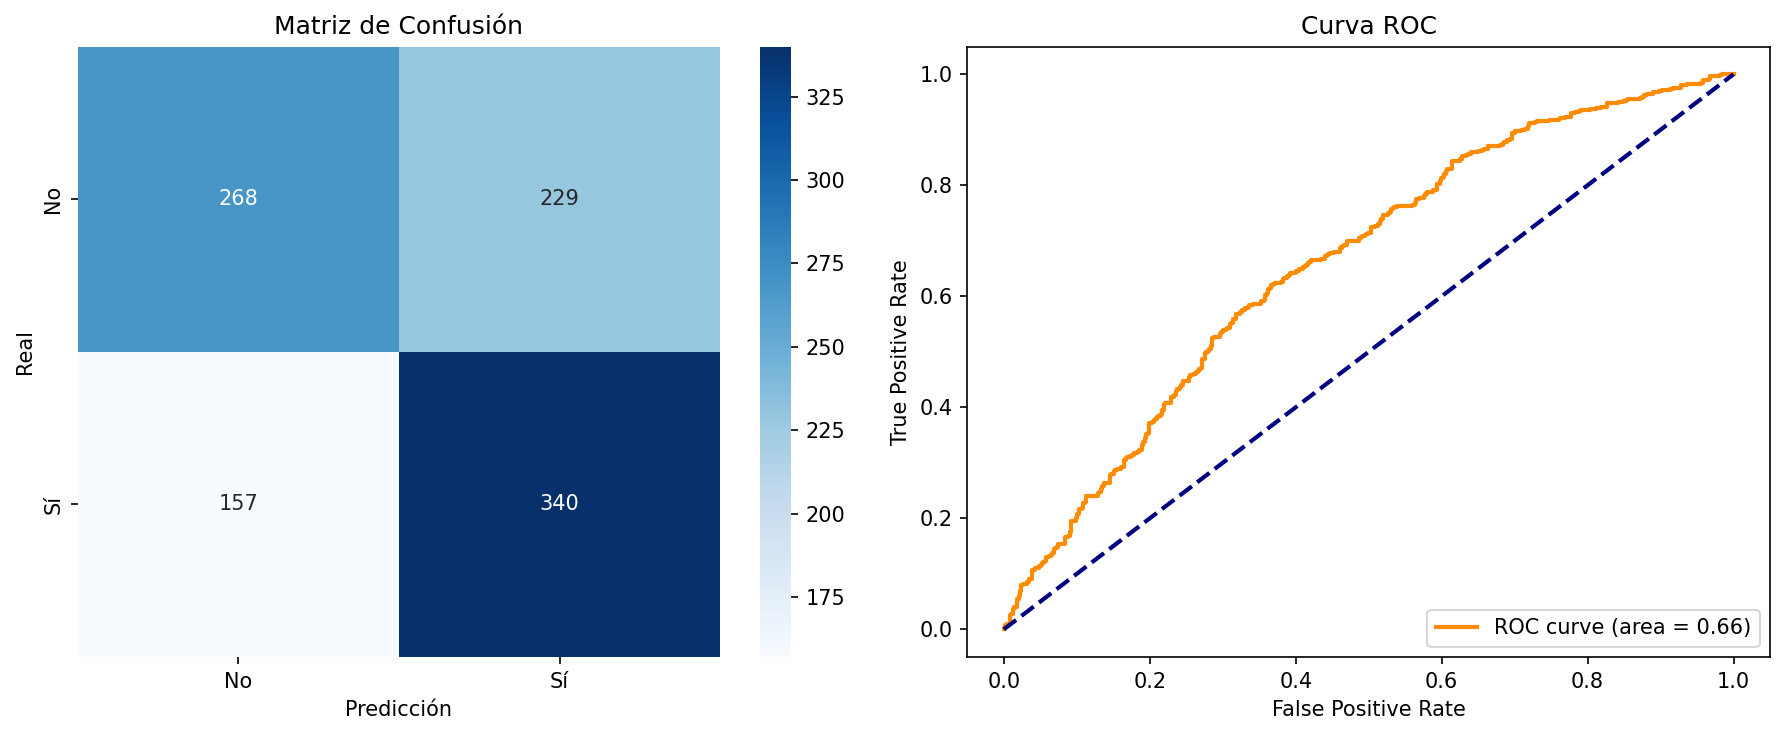

In [329]:
############################################
########### Regresion Logística ############
###########################################

# Modelo
modelo = LogisticRegression(random_state=42)

# Hiperparámetros
hyperparameters = {'classifier__C': [0.1, 1, 10], 
                    'classifier__max_iter': [100, 200]}

# Entrenamiento y evaluación
results_logreg = run_model_classifier(X_train, y_train, X_test, y_test, modelo, hyperparameters)

Iniciando búsqueda de hiperparámetros:
Mejores hiperparámetros: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5}
Reporte de clasificación:

              precision    recall  f1-score   support

         0.0       0.61      0.59      0.60       497
         1.0       0.60      0.62      0.61       497

    accuracy                           0.60       994
   macro avg       0.60      0.60      0.60       994
weighted avg       0.60      0.60      0.60       994

Matriz de confusión:

[[294 203]
 [191 306]]


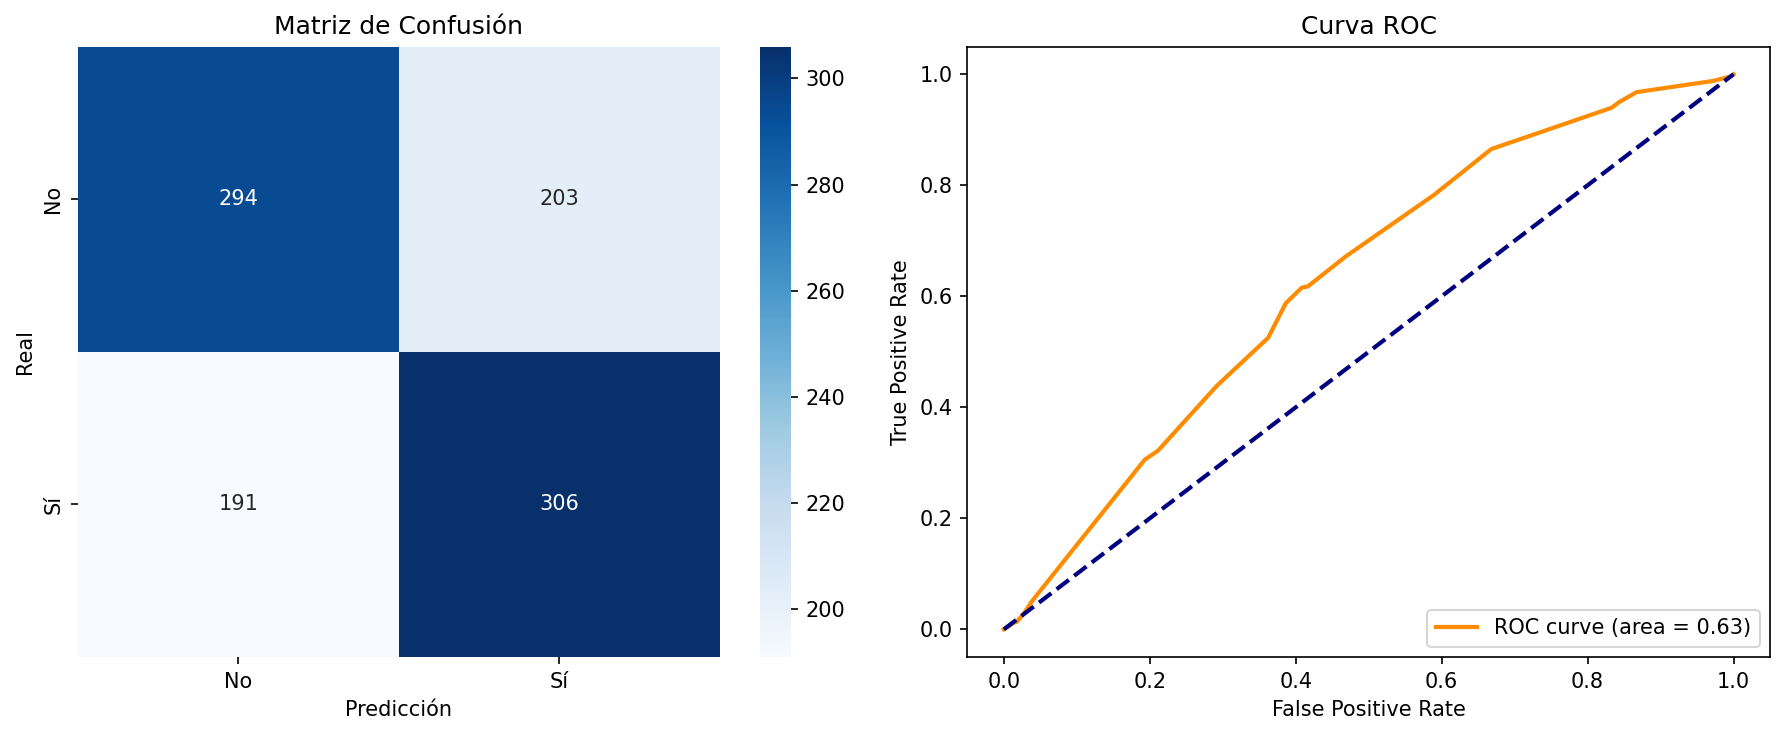

In [330]:
######################################
########### Decision Tree ############
######################################

# Modelo
modelo = DecisionTreeClassifier(random_state=42)

# Hiperparámetros
hyperparameters = {'classifier__max_depth': [3, 5, 10], 
                    'classifier__criterion': ['gini', 'entropy']}

# Entrenamiento y evaluación
results_dt = run_model_classifier(X_train, y_train, X_test, y_test, modelo, hyperparameters)


Iniciando búsqueda de hiperparámetros:


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1473: DataConversionW

Mejores hiperparámetros: {'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Reporte de clasificación:

              precision    recall  f1-score   support

         0.0       0.65      0.62      0.64       497
         1.0       0.64      0.67      0.66       497

    accuracy                           0.65       994
   macro avg       0.65      0.65      0.65       994
weighted avg       0.65      0.65      0.65       994

Matriz de confusión:

[[309 188]
 [163 334]]


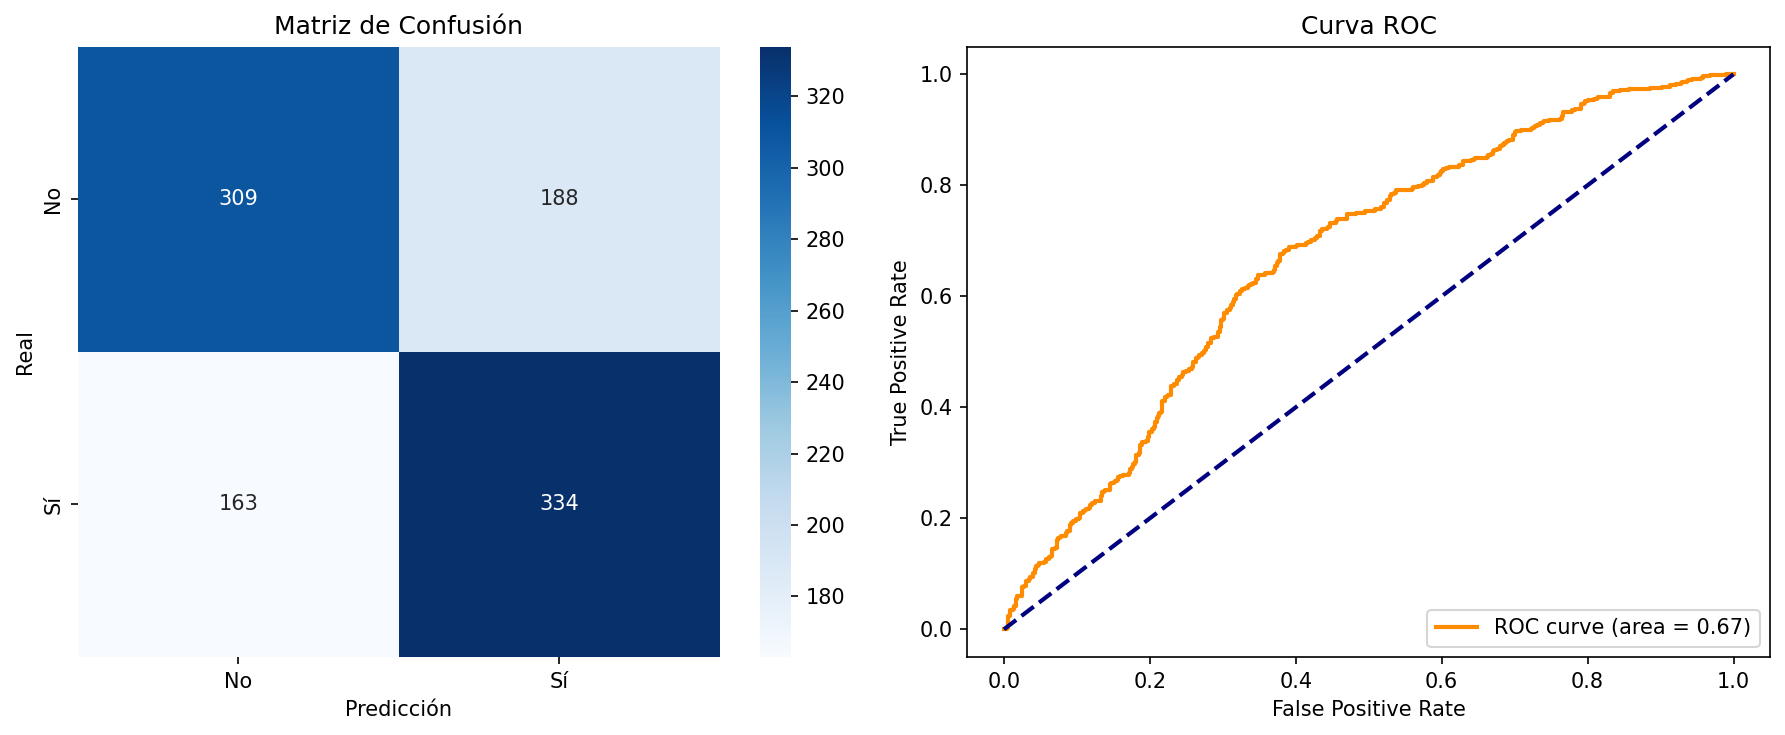

In [331]:
######################################
########### Random Forest ############
######################################

# Modelo
modelo = RandomForestClassifier(random_state=42)

# Hiperparámetros
hyperparameters = {'classifier__n_estimators': [50, 100, 200], 
                    'classifier__max_depth': [5, 10, 20]}

# Entrenamiento y evaluación
results_rf = run_model_classifier(X_train, y_train, X_test, y_test, modelo, hyperparameters)

# **3. Conclusiones**

## **3.1 Evaluación de las métricas de clasificación**

**Precisión global** \
El modelo tiene una precisión general del **65%**, lo que significa que clasifica correctamente el 65% de las muestras. Sin embargo, hay margen de mejora en la capacidad general del modelo.

**Clase 0 (Negativa)**
- **Precisión**: 0.65  
- **Recall**: 0.62 (indica que el modelo identificó el 62% de las muestras negativas correctamente).  
- **F1-Score**: 0.64, lo que sugiere un balance moderado entre precisión y recall para esta clase.  

**Clase 1 (Positiva)**
- **Precisión**: 0.64  
- **Recall**: 0.67 (indica que el modelo detectó correctamente el 67% de las muestras positivas).  
- **F1-Score**: 0.66, destacando un desempeño un poco mejor para la clase positiva en comparación con la negativa.  

**Métricas promedio**
En general, las métricas promedio (macro y ponderado) rondan el **0.65**, lo que refuerza la idea de un desempeño moderado del modelo.


PermutationExplainer explainer: 995it [14:25,  1.15it/s]                         
C:\Users\Enzo\AppData\Local\Temp\ipykernel_17240\3770077913.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


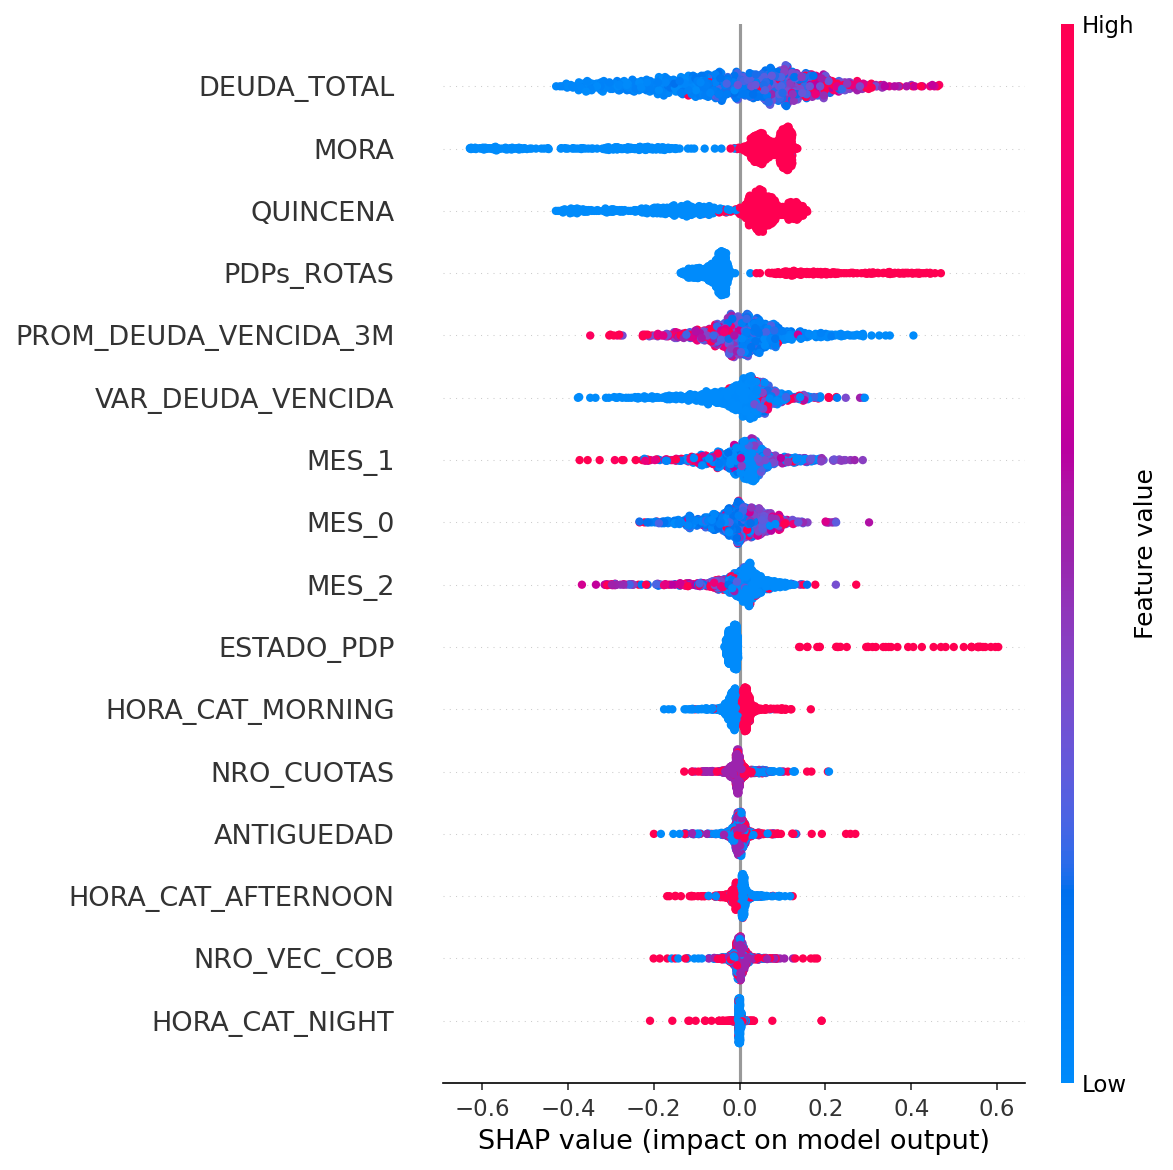

In [335]:
best_rf_model = results_rf['best_model'].named_steps['classifier']
explainer = shap.Explainer(best_rf_model.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

                  Feature  Importance
7             DEUDA_TOTAL    0.162116
10  PROM_DEUDA_VENCIDA_3M    0.133522
4                   MES_0    0.133463
9       VAR_DEUDA_VENCIDA    0.133335
5                   MES_1    0.090335
6                   MES_2    0.071060
1              PDPs_ROTAS    0.040398
8                    MORA    0.040211
15             ANTIGUEDAD    0.039166
0             NRO_VEC_COB    0.032162
14               QUINCENA    0.029603
2              ESTADO_PDP    0.027084
3              NRO_CUOTAS    0.026697
12       HORA_CAT_MORNING    0.014654
11     HORA_CAT_AFTERNOON    0.014474
13         HORA_CAT_NIGHT    0.011719


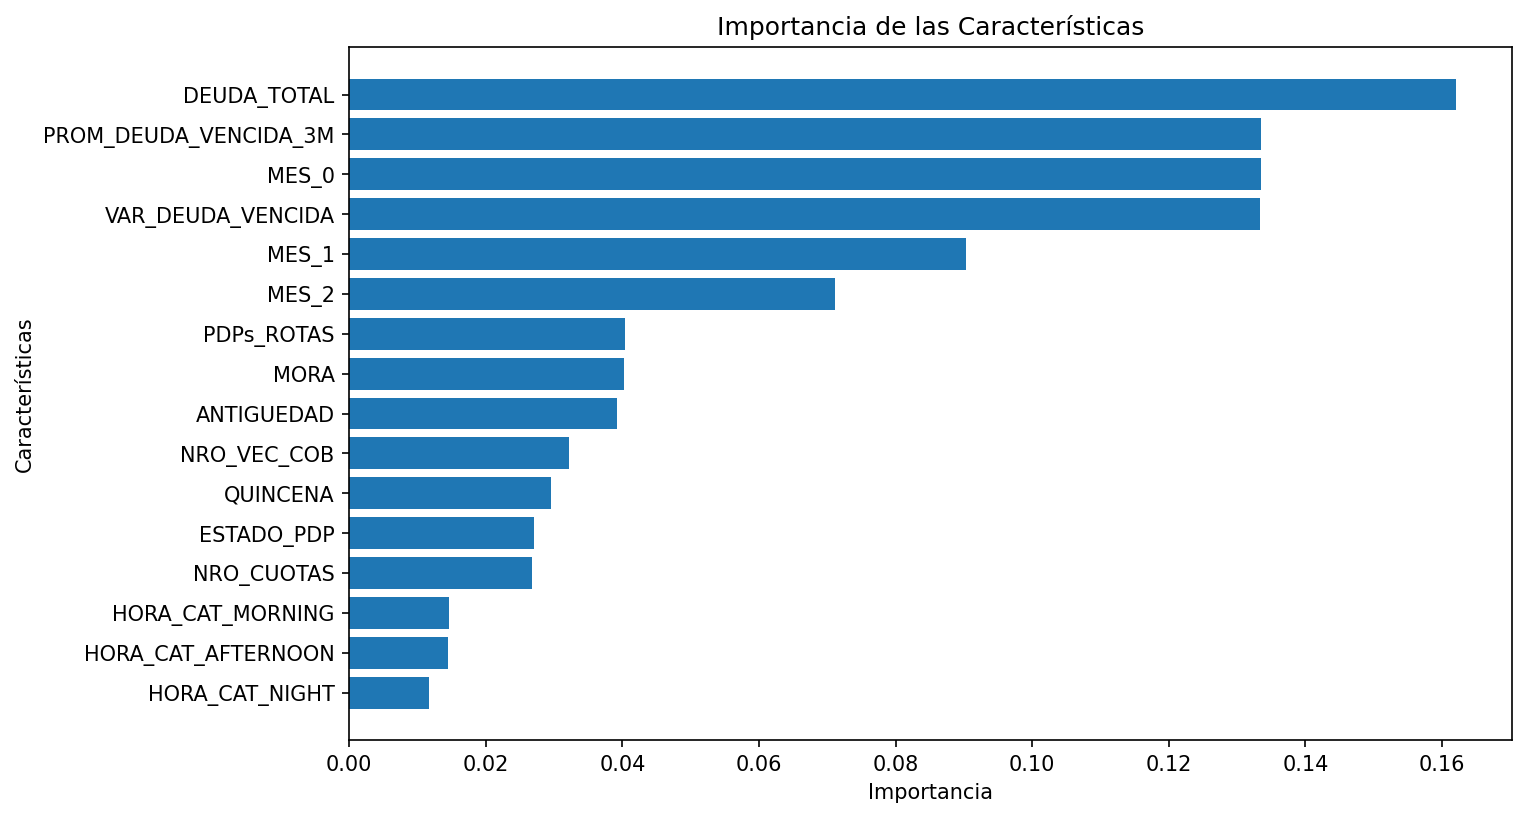

In [342]:
best_rf_model = results_rf['best_model']

importances = best_rf_model.named_steps['classifier'].feature_importances_

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características')
plt.gca().invert_yaxis()
plt.show()